In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path as osp
import sys

In [3]:
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def read_results(res_dir):
    out = {"shuffle": [], "no_shuffle": []}
    with open(
        osp.join(
            res_dir, "model.dill_results_shuffle-1_sort-0_zero-weight-1_keep-bias0.json"
        ),
        "r",
    ) as f:
        out["shuffle"].append(json.load(f))

    with open(
        osp.join(
            res_dir, "model.dill_results_shuffle-0_sort-1_zero-weight-1_keep-bias0.json"
        ),
        "r",
    ) as f:
        out["no_shuffle"].append(json.load(f))

    return out

In [22]:
oml_aug_results = read_results("results/meta/oml_aug/oml_zero_reset_b4_outer_500k_0/")
oml_sup_results = read_results("results/supervised/oml/oml_0/")
oml_sup_aug_results = read_results("results/supervised/oml/oml_aug_0/")

anml_results = read_results("results/meta/anml/anml_zero_25k_0/")
anml_aug_results = read_results("results/meta/anml/anml_zero_25k_aug_all_0/")
anml_sup_results = read_results("results/supervised/anml/anml_0/")

In [15]:
import scipy.stats as st
import numpy as np
from matplotlib.ticker import AutoMinorLocator

In [16]:
def groupby_and_ci(x, y):
    uniques = np.unique(x)
    out_mean = []
    out_ci = []
    y = np.array(y)
    for u in uniques:
        subset = y[x == u]
        out_mean.append(np.mean(subset))
        out_ci.append(st.norm.interval(alpha=0.95, loc=np.mean(subset), scale=st.sem(subset)))
    
    return uniques, out_mean, out_ci

In [17]:
def _plot_run(data, ax, label, linestyle, ci_linewidth=2, color=None, alpha=0.1):
    x, y = list(zip(*([(int(traj_length), acc) for (traj_length, ress) in data.items() for (lr, acc) in ress])))
    p, mean, ci = groupby_and_ci(x, y)

    ax.plot(p, mean, linestyle=linestyle, label=label, color=color)
    ax.fill_between(p, *list(zip(*ci)), alpha=alpha, color=color, linestyle=linestyle, linewidth=ci_linewidth)
    # return sns.lineplot(x=x, y=y, ax=ax, label=label, palette=("red",))
    
def get_data(results, phase, shuffle):
    shuffle = "shuffle" if shuffle else "no_shuffle"
    return {k: sum([l[phase][k] for l in results[shuffle]], []) for k in results[shuffle][0][phase].keys()}


In [18]:
import matplotlib

matplotlib.rcParams.update({'font.size': 16})

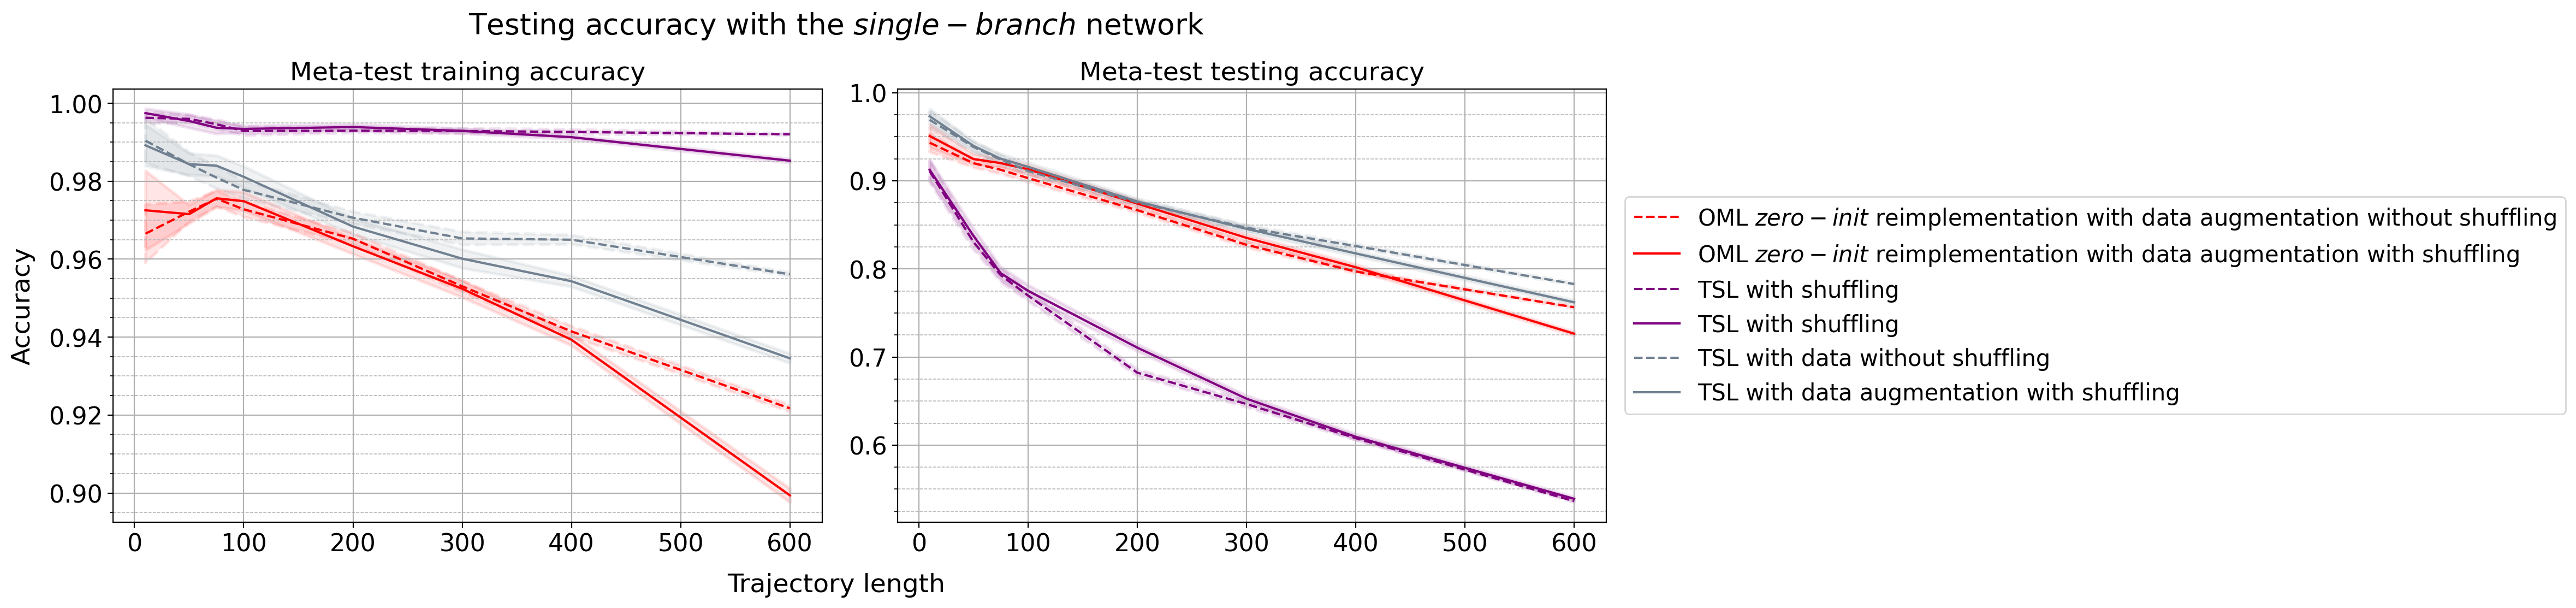

In [20]:
fig, (ax_train, ax_test) = plt.subplots(ncols=2, figsize=(24, 6), sharey=False, sharex=True, dpi=200)



# Reimpl
# _plot_run(get_data(reimpl_oml_results, "train", False), ax_train, "OML reimplementation without shuffling", linestyle="--", color="green")
# _plot_run(get_data(reimpl_oml_results, "test", False), ax_test, "OML reimplementation without shuffling", linestyle="--", color="green")

# _plot_run(get_data(reimpl_oml_results, "train", True), ax_train, "OML reimplementation with shuffling", linestyle="-", color="green")
# _plot_run(get_data(reimpl_oml_results, "test", True), ax_test, "OML reimplementation with shuffling", linestyle="-", color="green")

# Reimpl+
# _plot_run(get_data(oml_impr_results["none"], "train", False), ax_train, "OML $\it{zero-init}$ reimplementation without shuffling", linestyle="--", color="darkgoldenrod")
# _plot_run(get_data(oml_impr_results["none"], "test", False), ax_test, "OML $\it{zero-init}$ reimplementation without shuffling", linestyle="--", color="darkgoldenrod")

# _plot_run(get_data(oml_impr_results["none"], "train", True), ax_train, "OML $\it{zero-init}$ reimplementation with shuffling", linestyle="-", color="darkgoldenrod")
# _plot_run(get_data(oml_impr_results["none"], "test", True), ax_test, "OML $\it{zero-init}$ reimplementation with shuffling", linestyle="-", color="darkgoldenrod")

# Reimpl zero aug
_plot_run(get_data(oml_aug_results, "train", False), ax_train, "OML $\it{zero-init}$ reimplementation with data augmentation without shuffling", linestyle="--", color="red")
_plot_run(get_data(oml_aug_results, "test", False), ax_test, "OML $\it{zero-init}$ reimplementation with data augmentation without shuffling", linestyle="--", color="red")

_plot_run(get_data(oml_aug_results, "train", True), ax_train, "OML $\it{zero-init}$ reimplementation with data augmentation with shuffling", linestyle="-", color="red")
_plot_run(get_data(oml_aug_results, "test", True), ax_test, "OML $\it{zero-init}$ reimplementation with data augmentation with shuffling", linestyle="-", color="red")


# TSL
_plot_run(get_data(oml_sup_results, "train", False), ax_train, "TSL without shuffling", linestyle="--", color="purple")
_plot_run(get_data(oml_sup_results, "test", False), ax_test, "TSL with shuffling", linestyle="--", color="purple")

_plot_run(get_data(oml_sup_results, "train", True), ax_train, "TSL without shuffling", linestyle="-", color="purple")
_plot_run(get_data(oml_sup_results, "test", True), ax_test, "TSL with shuffling", linestyle="-", color="purple")

# TSL+Aug
_plot_run(get_data(oml_sup_aug_results, "train", False), ax_train, "TSL with data without shuffling", linestyle="--", color="slategray")
_plot_run(get_data(oml_sup_aug_results, "test", False), ax_test, "TSL with data without shuffling", linestyle="--", color="slategray")

_plot_run(get_data(oml_sup_aug_results, "train", True), ax_train, "TSL with data augmentation with shuffling", linestyle="-", color="slategray")
_plot_run(get_data(oml_sup_aug_results, "test", True), ax_test, "TSL with data augmentation with shuffling", linestyle="-", color="slategray")

fig.suptitle("Testing accuracy with the $\it{single-branch}$ network", x=0.33, y=0.95)
fig.supxlabel('Trajectory length', x=0.33, y=0.055, fontsize=17)
fig.supylabel("Accuracy", x=0.015, fontsize=17)
# ax_train.set_ylabel("Accuracy")

ax_train.set_title("Meta-test training accuracy", fontsize=17)
ax_test.set_title("Meta-test testing accuracy", fontsize=17)
ax_test.yaxis.set_tick_params(labelleft=True)


plt.subplots_adjust(wspace=0.1, right=0.75)


ax_train.yaxis.set_minor_locator(AutoMinorLocator(n=4))
ax_train.grid(True, which="major")
ax_train.grid(True, which="minor", linewidth=0.55, linestyle="--")
# ax_train.legend()

ax_test.yaxis.set_minor_locator(AutoMinorLocator(n=4))
ax_test.grid(True, which="major")
ax_test.grid(True, which="minor", linewidth=0.55, linestyle="--")
ax_test.legend(bbox_to_anchor=(1.01, 0.5), loc="center left", prop={"size": 15})

plt.tight_layout()

# plt.show()

# plt.savefig("oml_results.jpg", dpi=250)

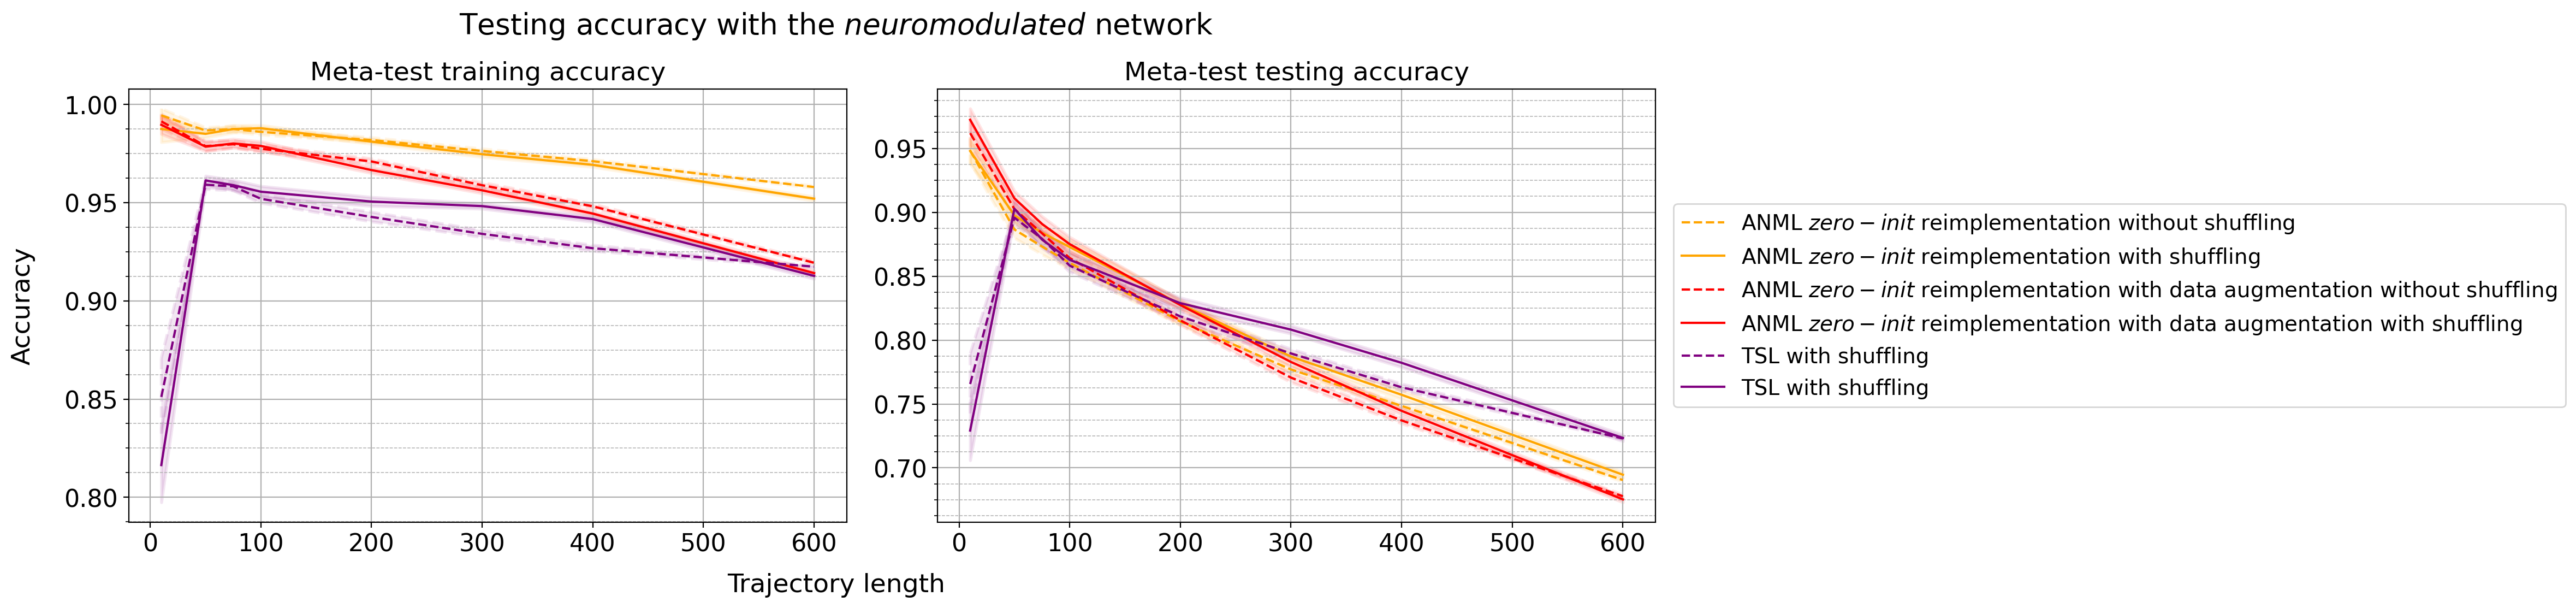

In [23]:
fig, (ax_train, ax_test) = plt.subplots(ncols=2, figsize=(24, 6), sharey=False, sharex=True, dpi=200)



# Reimpl+
_plot_run(get_data(anml_results, "train", False), ax_train, "ANML $\it{zero-init}$ reimplementation without shuffling", linestyle="--", color="orange")
_plot_run(get_data(anml_results, "test", False), ax_test, "ANML $\it{zero-init}$ reimplementation without shuffling", linestyle="--", color="orange")

_plot_run(get_data(anml_results, "train", True), ax_train, "ANML $\it{zero-init}$ reimplementation with shuffling", linestyle="-", color="orange")
_plot_run(get_data(anml_results, "test", True), ax_test, "ANML $\it{zero-init}$ reimplementation with shuffling", linestyle="-", color="orange")


# Reimpl++AugAll
k = "all"
_plot_run(get_data(anml_aug_results, "train", False), ax_train, "ANML $\it{zero-init}$ reimplementation with data augmentation without shuffling", linestyle="--", color="red")
_plot_run(get_data(anml_aug_results, "test", False), ax_test, "ANML $\it{zero-init}$ reimplementation with data augmentation without shuffling", linestyle="--", color="red")

_plot_run(get_data(anml_aug_results, "train", True), ax_train, "ANML $\it{zero-init}$ reimplementation with data augmentation with shuffling", linestyle="-", color="red")
_plot_run(get_data(anml_aug_results, "test", True), ax_test, "ANML $\it{zero-init}$ reimplementation with data augmentation with shuffling", linestyle="-", color="red")


# TSL
_plot_run(get_data(anml_sup_results, "train", False), ax_train, "TSL with shuffling", linestyle="--", color="purple")
_plot_run(get_data(anml_sup_results, "test", False), ax_test, "TSL with shuffling", linestyle="--", color="purple")

_plot_run(get_data(anml_sup_results, "train", True), ax_train, "TSL with shuffling", linestyle="-", color="purple")
_plot_run(get_data(anml_sup_results, "test", True), ax_test, "TSL with shuffling", linestyle="-", color="purple")


fig.suptitle("Testing accuracy with the $\it{neuromodulated}$ network", x=0.33, y=0.95)
fig.supxlabel('Trajectory length', x=0.33, y=0.055, fontsize=17)
fig.supylabel("Accuracy", x=0.015, fontsize=17)
# ax_train.set_ylabel("Accuracy")

ax_train.set_title("Meta-test training accuracy", fontsize=17)
ax_test.set_title("Meta-test testing accuracy", fontsize=17)
ax_test.yaxis.set_tick_params(labelleft=True)

plt.subplots_adjust(wspace=0.1, right=0.75)

ax_train.yaxis.set_minor_locator(AutoMinorLocator(n=4))
ax_train.grid(True, which="major")
ax_train.grid(True, which="minor", linewidth=0.55, linestyle="--")
# ax_train.legend()

ax_test.yaxis.set_minor_locator(AutoMinorLocator(n=4))
ax_test.grid(True, which="major")
ax_test.grid(True, which="minor", linewidth=0.55, linestyle="--")
ax_test.legend(bbox_to_anchor=(1.01, 0.5), loc="center left", prop={"size": 14})

plt.tight_layout()

# plt.savefig("anml_results.jpg", dpi=250)